In [1]:
# 1. 파이썬 코드에서 Matplotlib 폰트 설정
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from itertools import combinations
from collections import Counter

# 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정이 완료되었습니다.")


한글 폰트 설정이 완료되었습니다.


In [2]:
# 3. 데이터 로드 및 통합 (모든 문제 풀이의 시작점)
# dataframe 확인해라!
try:
    orders_df = pd.read_csv('../data/orders.csv')
    payments_df = pd.read_csv('../data/payments.csv')
    products_df = pd.read_csv('../data/products.csv')
    shipping_df = pd.read_csv('../data/shipping.csv')
    customers_df = pd.read_csv('../data/customers.csv')

    # 모든 데이터프레임 병합
    df = pd.merge(orders_df, payments_df, on='order_id', how='left')
    df = pd.merge(df, products_df, on='product_id', how='left')
    df = pd.merge(df, customers_df, on='customer_id', how='left')
    df = pd.merge(df, shipping_df, on='order_id', how='left')

    # 데이터 전처리
    date_cols = ['order_date', 'payment_date', 'join_date', 'shipping_start_date', 'shipping_end_date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df['total_sales'] = df['quantity'] * df['price']
    
    print("데이터 로드 및 통합이 완료되었습니다.")

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")


데이터 로드 및 통합이 완료되었습니다.


In [3]:
# 1. 필요한 열만 선택하여 새로운 데이터프레임 생성
# 원본 df에서 'order_date', 'category', 'total_sales' 열만 분리해 오고
# 원본을 보호하기 위해 copy()로 복사본을 만듭니다.
df_data = df[['order_date', 'category', 'total_sales']].copy()

# 2. 'order_date' 열에서 연도-월 정보만 추출하여 'year_month'라는 새 컬럼 생성
# dt.to_period('M') 메서드는 datetime 타입에서 년-월 단위 기간 데이터로 변환합니다.
df_data['year_month'] = df_data['order_date'].dt.to_period('M')
df_data

,order_date,category,total_sales,year_month
0,2023-10-20 09:41:43,화장품,42000,2023-10
1,2023-10-20 11:14:49,스포츠용품,44000,2023-10
2,2023-10-20 13:26:26,스포츠용품,169500,2023-10
3,2023-10-20 13:55:14,스포츠용품,17900,2023-10
4,2023-10-20 14:12:47,식품,153800,2023-10
...,...,...,...,...
9995,2025-10-19 09:01:57,도서,97400,2025-10
9996,2025-10-19 10:26:35,의류,27300,2025-10
9997,2025-10-19 11:29:35,화장품,210000,2025-10
9998,2025-10-19 12:20:49,화장품,245700,2025-10


In [ ]:
# 3. 'category'와 'year_month'별로 그룹화하여 각 그룹의 'total_sales' 합계 계산
# groupby()를 사용해 그룹핑 후 sum()으로 매출 합계를 구합니다.
# reset_index()를 통해 결과를 다시 데이터프레임 형태로 변환합니다.
df_category_monthly_sales = df_data.groupby(['category', 'year_month'])['total_sales'].sum().reset_index()

# 4. 각 카테고리별로 월별 매출 성장률 계산
# pct_change() 함수는 이전 월 대비 변화율(성장률)을 계산합니다.
# groupby('category')로 카테고리별 분리하여 적용해야 정확한 성장률을 구할 수 있습니다.
df_category_monthly_sales['growth_rate'] = df_category_monthly_sales.groupby('category')['total_sales'].pct_change()

# 5. 각 카테고리별 평균 성장률 산출
# growth_rate 컬럼을 기준으로 카테고리별 평균 성장률을 구하고,
# sort_values(ascending=False)로 내림차순 정렬하여 가장 높은 성장률부터 볼 수 있게 합니다.
growth_rate_by_category = df_category_monthly_sales.groupby('category')['growth_rate'].mean().sort_values(ascending=False)

# 6. 피벗 테이블 생성
# index='year_month'로 월별을 행 인덱스로, columns='category'로 카테고리를 열로 지정,
# 매출 'total_sales'가 값이 되는 형태로 가공하여 비교와 시각화에 적합하도록 만듭니다.
pivot_sales = df_category_monthly_sales.pivot_table(index='year_month', columns='category', values='total_sales')
pivot_sales


category,가구,도서,스포츠용품,식품,의류,전자제품,화장품
year_month,,,,,,,
2023-10,3165100.0,2359100.0,4126000.0,3732300.0,4516800.0,4995400.0,2292400.0
2023-11,10030900.0,5774700.0,8806100.0,11284100.0,12454200.0,10885200.0,8339700.0
2023-12,9636900.0,7122300.0,10158400.0,9791700.0,10479600.0,10537200.0,10005500.0
2024-01,11262300.0,6823600.0,9569900.0,13437900.0,14199200.0,9979600.0,8609500.0
2024-02,6671000.0,7035900.0,11717200.0,8857600.0,12407000.0,10322100.0,6270700.0
2024-03,9623400.0,5440000.0,9522900.0,11879200.0,17909800.0,13202900.0,11082100.0
2024-04,7316300.0,6284800.0,10877500.0,9084300.0,13088500.0,10197300.0,8500100.0
2024-05,7388000.0,5863300.0,7337900.0,12053200.0,13743900.0,13666200.0,10153600.0
2024-06,7563700.0,9541600.0,7384400.0,11656500.0,14391100.0,13712400.0,8236300.0


카테고리별 평균 월별 성장률:
category
화장품      0.127811
가구       0.098994
식품       0.087353
의류       0.079554
도서       0.078011
스포츠용품    0.073715
전자제품     0.048982
dtype: float64


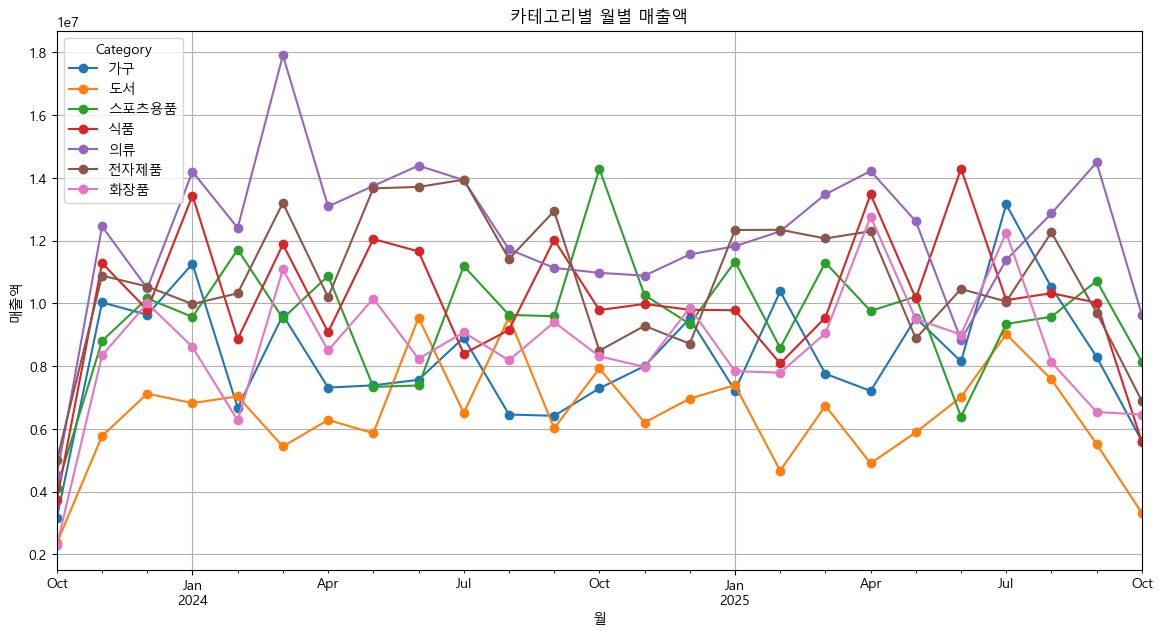

In [ ]:
# 7. 평균 성장률 결과 출력
print('카테고리별 평균 월별 성장률:')
print(growth_rate_by_category.to_string())
print(f"dtype: {growth_rate_by_category.dtype}") # 걍 심심해서 출력해봄

# 8. 시각화
# pivot_sales를 이용해 카테고리별 월별 매출 변화를 선 그래프로 그립니다.
# marker='o'는 각 데이터 포인트를 동그라미로 표시하고,
# figsize=(10,8)로 그림 크기를 지정합니다.
pivot_sales.plot(marker='o', figsize=(14, 7))
plt.title('카테고리별 월별 매출액')  # 그래프 제목 설정
plt.xlabel('월')                    # x축 라벨 설정
plt.ylabel('매출액')                # y축 라벨 설정
plt.legend(title='Category', loc='upper left')  # 범례 제목 및 위치 설정
plt.grid(True)                    # 그래프에 격자 추가
plt.show()                       # 그래프 화면에 출력
